In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings("ignore")

In [2]:
# DATA PATH
RAW_DATA_PATH = os.path.join("..","datasets","raw","airline_passengers.csv")
RAW_DATA_PATH

'../datasets/raw/airline_passengers.csv'

In [3]:
air = pd.read_csv(RAW_DATA_PATH, parse_dates=['Month'], index_col='Month', squeeze=True)
air

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
             ... 
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Name: AirPassengers, Length: 144, dtype: int64

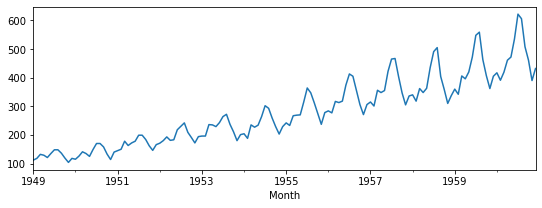

In [4]:
air.plot(figsize=(9,3))
plt.show()

## Time Series Decomposition

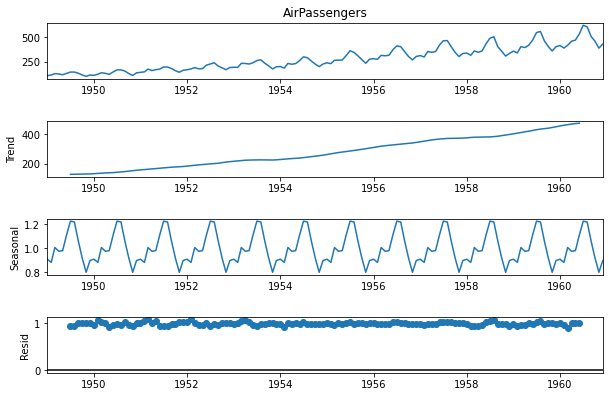

In [5]:
result = seasonal_decompose(air, model='multiplicative')
fig = result.plot()
fig.set_size_inches((9,6))
#plt.savefig('../img/seasonal_decompose.jpg')
plt.show()

### Autocorrelation

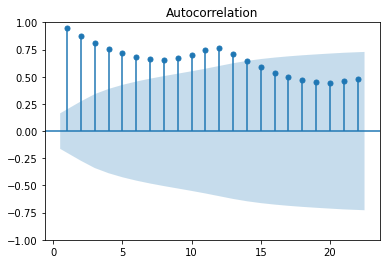

In [6]:
plot_acf(air, zero=False)
plt.show()

## Augmented Dickey-Fuller Test

In [7]:
def adFullerResult(df):
    result = adfuller(df)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

adFullerResult(air)

ADF Statistic: 0.815369
p-value: 0.991880
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


## Differencing

### First Differencing 

In [8]:
# First Differencing
air_diff1 = air.diff().dropna()

adFullerResult(air_diff1)

ADF Statistic: -2.829267
p-value: 0.054213
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


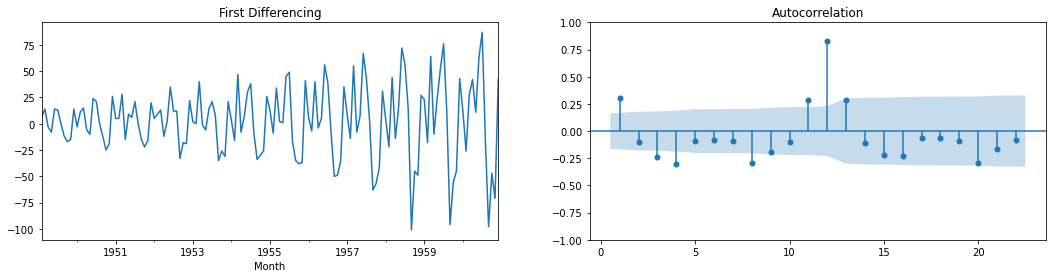

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))

air_diff1.plot(ax=ax[0])
ax[0].set_title("First Differencing")
plot_acf(air_diff1, zero=False, ax=ax[1])
plt.show()

### Second Differencing

In [10]:
air_diff2 = air.diff().diff().dropna()

adFullerResult(air_diff2)

ADF Statistic: -16.384232
p-value: 0.000000
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


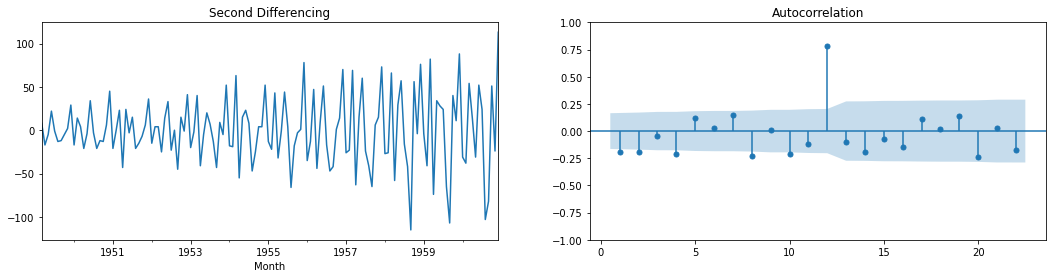

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))

air_diff2.plot(ax=ax[0])
ax[0].set_title("Second Differencing")
plot_acf(air_diff2, zero=False, ax=ax[1])
plt.show()

## Autocorrelation and Partial Autocorrelation

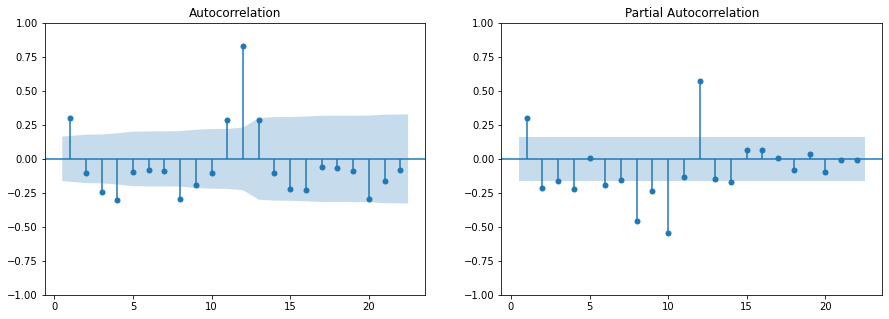

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plot_acf(air_diff1, zero=False, ax=ax[0])
plot_pacf(air_diff1, method='ywm', zero=False, ax=ax[1])
plt.show()

## Searching for best order

In [13]:
akaike = list()
for p in range(1,8):
    for q in range(1,8):
        try:
            model = ARIMA(air_diff1, order=(p,1,q))
            res = model.fit()
            akaike.append([p,q, round(res.aic, 1)])
        except:
            akaike.append([p,q, None])

aic = pd.DataFrame(akaike, columns=["p","q","aic"])
aic.sort_values(by="aic", ignore_index=True, )[:3]

,p,q,aic
0,4,7,1332.4
1,7,7,1333.7
2,6,7,1333.9


In [14]:
model = ARIMA(air_diff1, order=(4,1,7))
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          AirPassengers   No. Observations:                  143
Model:                 ARIMA(4, 1, 7)   Log Likelihood                -654.206
Date:                Thu, 18 Aug 2022   AIC                           1332.412
Time:                        14:08:32   BIC                           1367.882
Sample:                    02-01-1949   HQIC                          1346.825
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7255      0.049    -14.873      0.000      -0.821      -0.630
ar.L2         -0.1168      0.069     -1.682      0.093      -0.253       0.019
ar.L3         -0.4463      0.092     -4.827      0.000      -0.628      -0.265
ar.L4         -0.8342      0.063    -13.214      0.000      -0.958      -0.710
ma.L1         -0.0962      0.488     -0.197      0.844      -1.054       0.861
ma.L2         -0.9376      0.491     -1.911      0.056      -1.899       0.024
ma.L3          0.1997      0.720      0.277      0.781      -1.211       1.610
ma.L4          0.1111      0.848      0.131      0.896      -1.551       1.773
ma.L5         -1.0711      0.843     -1.270      0.204      -2.724       0.582
ma.L6          0.2143      0.384      0.558      0.577      -0.538       0.967
ma.L7          0.8159      0.537      1.518      0.129      -0.237       1.869
sigma2       530.9832    352.371      1.507      0.132    -159.651    1221.617
===================================================================================
Ljung-Box (L1) (Q):                   3.37   Jarque-Bera (JB):                 0.88
Prob(Q):                              0.07   Prob(JB):                         0.64
Heteroskedasticity (H):               5.48   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Splitting Data

In [15]:
air[:-6].to_csv('../datasets/processed/train.csv')
air[-6:].to_csv('../datasets/processed/test.csv')